In [1]:
%pylab --no-import-all inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import scipy, scipy.linalg, scipy.sparse, scipy.sparse.linalg, scipy.fftpack
plt.rcParams['figure.figsize'] = 16, 9
from IPython.display import HTML

Populating the interactive namespace from numpy and matplotlib


Initial wave packet:

In [2]:
x_0 = -10.
k = 5.
a = 1

In [3]:
def wavepacket(x, t=0, a=a, k=k, x_0=x_0):
    return (
        (np.pi * a**2 / 2)**(-1. / 4) *
        np.sqrt(a**2 / (a**2 + 2j * t)) *
        np.exp(1j*(k*x - k**2 * t / 2)) *
        np.exp(-(x - x_0 - k * t)**2 / (a**2 + 2j * t))
    )

(Discretized) Hamiltonian for given potential:

In [4]:
def hamiltonian(V, xs, dx):
    diag = V(xs) + 1. / dx**2
    offdiag = -0.5 / dx**2 * np.ones(x_steps)
    return scipy.sparse.dia_matrix(
        ([diag, offdiag, offdiag], [0, -1, 1]), 
        shape=(len(xs), len(xs))
    )

Video recording:

In [5]:
def record_video(filename, wave_step, xs, dx, ts, dt, V=None):
    fig, ax1 = plt.subplots()
    if V:
        ax2 = ax1.twinx()
        ax2.set_aspect('equal')
        ax2.plot(xs, V(xs), '--', color='gray')
        for tl in ax2.get_yticklabels():
            tl.set_color('gray')
    
    line_real, = ax1.plot([], [], 'r-', label="Re \Psi")
    line_imag, = ax1.plot([], [], 'g-', label="Im \Psi")
    line_abs_sqr, = ax1.plot([], [], 'b-', lw=2, label="|\Psi|^2")
    ax1.set_xlim(min(xs), max(xs))
    ax1.set_ylim(-1, 1)
    ax1.set_xlabel("x")
    ax1.axvline(0, ls="--", color="gray")
    ax1.legend()

    def update(t):
        psi = wave_step(dt, t)
        line_real.set_data(xs, psi.real)
        line_imag.set_data(xs, psi.imag)
        line_abs_sqr.set_data(xs, np.abs(psi)**2)
        return [line_real, line_imag, line_abs_sqr]

    anim = FuncAnimation(fig, update, ts, blit=True, interval=1000 * dt)
    
    anim.save(filename, fps=1 / dt)
    plt.close(fig)

# 1. "No" Wall

Discretization parameters:

In [6]:
x_min = -50
x_max = 50
x_steps = 5000
xs, dx = np.linspace(x_min, x_max, x_steps, retstep=True)

t_min = 0
t_max = 15
t_steps = 1000 # use 100 for debugging ;-)
ts, dt = np.linspace(t_min, t_max, t_steps, retstep=True)

In [7]:
V_free = np.vectorize(lambda x: 0)
H_free = hamiltonian(V_free, xs=xs, dx=dx)

Exact Solution:

In [8]:
record_video('step1-exact.mp4', lambda dt, t: wavepacket(xs, t), xs=xs, dx=dx, ts=ts, dt=dt)

It is apparent from the analytical solution that the time-evolved wavepacket is again a wavepacket:
More precisely, the probability amplitude follows a Gaussian distribution with center $x_0 + k_0 t$ and spread $\sqrt{(a/2)^2 + (t/a)^2}$.
The probability current is given by $\mathrm{Im} \Psi^* \nabla \Psi$. It can be interpreted as $v(x) |\Psi(x)|^2$, with $v(x)$ the "local velocity", and hence its integral gives the average velocity, which for our wave packet is equal to $k_0$. The local kinetic energy can also be readily computed. Here is a snapshot:

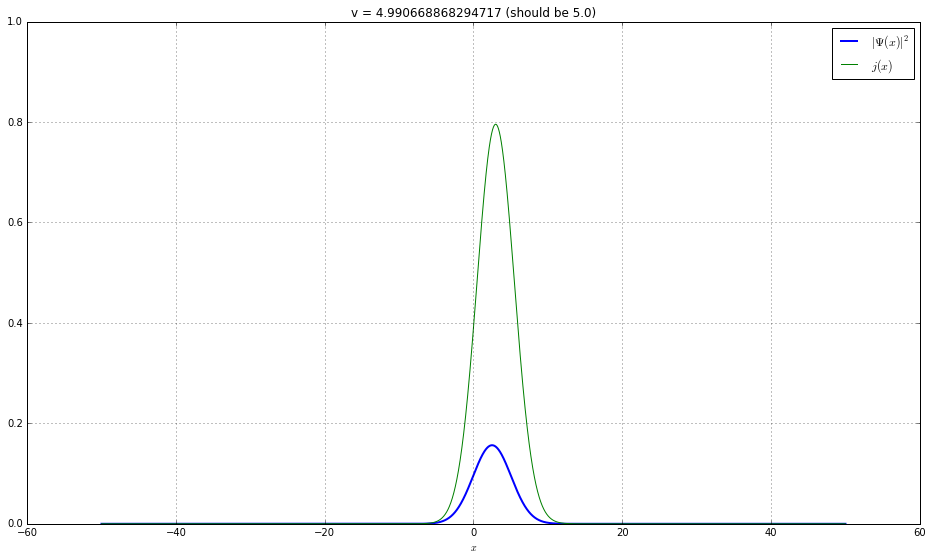

In [9]:
def prob_current(psi, dx):
    psi_mean = (psi[1:] + psi[:-1]) / 2. 
    psi_prime = np.diff(psi).conj() / dx
    return -(psi_mean * psi_prime).imag

def velocity(psi, dx):
    return sum(prob_current(psi, dx) * dx)

t = 2.5
xs_mid = (xs[1:]+xs[:-1])/2

plt.ylim(bottom=0)
plt.plot(xs, np.abs(wavepacket(xs, t))**2, color="blue", lw=2, label="$|\Psi(x)|^2$")
plt.plot(xs_mid, prob_current(wavepacket(xs, t), dx), color="green", label="$j(x)$")
plt.xlabel('$x$')
plt.grid()
plt.title('v = {} (should be {})'.format(velocity(wavepacket(xs, t), dx), k))
plt.legend()
plt.show()

Spectral time evolution:

In [10]:
class SpectralEvolution:
    def __init__(self, H, initial_psi):
        self.H = H.todense()
        self.energies, self.eigenstates = scipy.linalg.eigh(self.H)
        self.initial_psi = np.dot(self.eigenstates.T.conj(), initial_psi)   # to get a unit vector, we should multiply by sqrt(dx)    
    
    def __call__(self, dt, t):
        psi = np.exp(-1j * self.energies * t) * self.initial_psi
        return np.dot(self.eigenstates, psi)

In [11]:
evolution = SpectralEvolution(H_free, wavepacket(xs))
# for timing we just choose a random time
%timeit evolution(None, 0.2)

1 loop, best of 3: 732 ms per loop


In [12]:
record_video('step1-spectral.mp4', SpectralEvolution(H_free, wavepacket(xs)), xs=xs, dx=dx, ts=ts, dt=dt)

Forward Euler scheme:

In [13]:
import functools

class EulerEvolution:
    def __init__(self, H, initial_psi):
        self.H = H # np.array(H.todense())
        self.current_psi = initial_psi.reshape(-1, 1)

    # Note that the cached function will not update if 
    # 'self' changes -- if we try to update self.H this
    # approach will not work
    @functools.lru_cache(maxsize=1)
    def _operator(self, dt):
        return scipy.sparse.identity(x_steps) - 1j * dt * self.H

    def __call__(self, dt, t):
        A = self._operator(dt)
        psi = A.dot(self.current_psi)
        self.current_psi = psi / np.linalg.norm(psi) * np.linalg.norm(self.current_psi)
        return self.current_psi

In [14]:
evolution = EulerEvolution(H_free, wavepacket(xs))
%timeit evolution(dt, None)

The slowest run took 19.67 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 642 µs per loop


In [15]:
record_video('step1-euler.mp4', EulerEvolution(H_free, wavepacket(xs)), xs=xs, dx=dx, ts=ts, dt=dt)

Forward/Backward stable, unitary scheme:

In [16]:
class StableEvolution:
    def __init__(self, H, initial_psi):
        self.H = H
        self.current_psi = initial_psi
    
    @functools.lru_cache(maxsize=1)
    def _operator(self, dt):
        return scipy.sparse.identity(len(self.current_psi)) - 0.5j * dt * self.H
    
    @functools.lru_cache(maxsize=1)
    def _operator_conj(self, dt):
        return self._operator(dt).conj()
        
    def __call__(self, dt, t):
        tmp = self._operator(dt).dot(self.current_psi)
        self.current_psi = scipy.sparse.linalg.spsolve(self._operator_conj(dt), tmp)
        return self.current_psi

In [17]:
evolution = StableEvolution(H_free, wavepacket(xs))
%timeit evolution(dt, None)

100 loops, best of 3: 7.3 ms per loop


In [18]:
record_video('step1-stable.mp4', StableEvolution(H_free, wavepacket(xs)), xs=xs, dx=dx, ts=ts, dt=dt)

Split operator method (assumes periodic b.c., hence only valid as long as the wave function does not exceed x_min or x_max):

In [19]:
class SplitOperatorMethod:
    def __init__(self, V, initial_psi, xs):
        self.V = V(xs)
        self.current_psi = initial_psi
        freqs = scipy.fftpack.fftfreq(len(xs))
        self.neg_laplace = (2 * np.pi * (len(xs) - 1) / (max(xs) - min(xs)) * freqs)**2

    @functools.lru_cache(maxsize=1)
    def _exp_V(self, dt):
        return np.exp(-0.5j * dt * self.V)
    
    @functools.lru_cache(maxsize=1)
    def _exp_neg_laplace(self, dt):
        return np.exp(-1j * dt * self.neg_laplace / 2)
        
    def __call__(self, dt, t):
        exp_V = self._exp_V(dt)
        psi = exp_V * self.current_psi
        psi = scipy.fftpack.fft(psi)
        psi = self._exp_neg_laplace(dt) * psi
        psi = scipy.fftpack.ifft(psi)
        self.current_psi = exp_V * psi
        return self.current_psi



In [20]:
evolution = SplitOperatorMethod(V_free, wavepacket(xs), xs)
%timeit evolution(dt, None)

The slowest run took 6.83 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 670 µs per loop


In [21]:
record_video('step1-split.mp4', SplitOperatorMethod(V_free, wavepacket(xs), xs), xs=xs, dx=dx, ts=ts, dt=dt)

# 2. Infinite Wall

The tridiagonal Hamiltonian for the kinetic part that we set up above automatically implements vanishing boundary conditions at $x_{\min}$ and $x_{\max}$. Thus we merely set $x_{\max} = 0$:

In [22]:
x_min = -45
x_max = 0
x_steps = 1000
xs, dx = np.linspace(x_min, x_max, x_steps, retstep=True)

V_free = np.vectorize(lambda x: 0)
H_free = hamiltonian(V_free, xs=xs, dx=dx)

record_video('step2-spectral.mp4', SpectralEvolution(H_free, wavepacket(xs)), xs=xs, dx=dx, ts=ts, dt=dt)

# 3. Tilted Wall

Re-set simulation range:

In [23]:
x_min = -20
x_max = 50
x_steps = 1000
xs, dx = np.linspace(x_min, x_max, x_steps, retstep=True)

Potential:

In [24]:
def V_wall(theta_deg):
    m = np.tan(theta_deg*2*np.pi/360)
    return np.vectorize(lambda x: max(.0, m*x))

def H_wall(theta_deg, xs, dx):
    return hamiltonian(V_wall(theta_deg), xs=xs, dx=dx)

Time evolution of the wave function and of the average velocity:

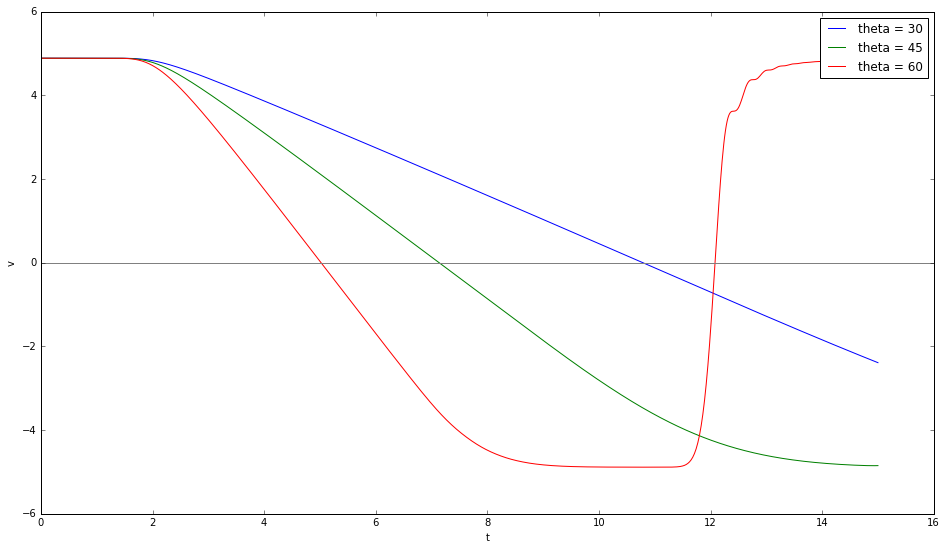

In [25]:
def velocities(theta_deg):
    evol = SpectralEvolution(H_wall(theta_deg, xs=xs, dx=dx), wavepacket(xs))
    vs = [velocity(wavepacket(xs, 0), dx=dx)]
    for t in ts[1:]:
        psi = evol(dt, t)
        vs.append(velocity(psi, dx=dx))
    return vs

plt.xlabel("t")
plt.ylabel("v")
for theta_deg in [30, 45, 60]:
    vs = velocities(theta_deg)
    plt.plot(ts, vs, label="theta = %d" % theta_deg)
    record_video('step3-spectral-%d.mp4' % theta_deg, 
                 SpectralEvolution(H_wall(theta_deg, xs=xs, dx=dx), wavepacket(xs)), 
                 #V_wall(theta_deg), 
                 xs=xs, dx=dx, ts=ts, dt=dt
                )
plt.legend()
plt.axhline(0, color="gray")
plt.savefig("step3-velocities.png")